In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['font.family']      = 'Arial'

In [2]:
# SUBFUNCTIONS

def merge_capacity_data(results_dict,relative=False):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        if not relative:
            df = results_dict[k].results_capacities
        else:
            df = results_dict[k].results_capacity_change
        capacities = capacities.append(df,ignore_index=True)
    return capacities


def get_relative_capacities(results_dict):
    capacities = merge_capacity_data(results_dict)
    # get bas and delta dfs
    bas   = capacities.loc[capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    delta = capacities.loc[~capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    # group
    bas   = bas.groupby(by=['scenario','technology','territory']).max().reset_index()
    delta = delta.groupby(by=['scenario','technology','territory']).max().reset_index()
    # map baseline capacities
    bas = bas.set_index('node')['value'].to_dict()
    delta['bas_cap'] = delta.node.map(bas)
    # compute delta
    delta['relative_change'] = delta['value'] - delta['bas_cap']
    return delta


def merge_cost_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    costs = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_costs
        costs = costs.append(df,ignore_index=True)
    return costs


def export_results_for_chord(merged_results,scenario):
    '''Export a csv for chord plots
    '''
    df = merged_results[scenario].results_edge_flows.copy()

    df['from_territory'] = ''
    df['to_territory'] = ''
    df = df[df.from_id.str.contains('generation')].reset_index(drop=True)

    df.loc[df.from_id.str.contains('israel'),'from_territory'] = 'ISR'
    df.loc[df.from_id.str.contains('west_bank'),'from_territory'] = 'WBK'
    df.loc[df.from_id.str.contains('gaza'),'from_territory'] = 'GZA'
    df.loc[df.from_id.str.contains('jordan'),'from_territory'] = 'JOR'
    df.loc[df.from_id.str.contains('egypt'),'from_territory'] = 'EGY'

    df.loc[df.to_id.str.contains('israel'),'to_territory'] = 'ISR'
    df.loc[df.to_id.str.contains('west_bank'),'to_territory'] = 'WBK'
    df.loc[df.to_id.str.contains('gaza'),'to_territory'] = 'GZA'
    df.loc[df.to_id.str.contains('jordan'),'to_territory'] = 'JOR'
    df.loc[df.to_id.str.contains('egypt'),'to_territory'] = 'EGY'
    
    df = df[['from_territory','to_territory','value']]
    df = df.groupby(by=['from_territory','to_territory']).sum().reset_index()
    
    # units?
    df.value = df.value.divide(10**3)
    # save
    df.to_csv('plots/chord_data/' + scenario + '.csv',index=False)
    print('done.')
    
    
def map_territory(df,on):
    '''Map territory onto dataframe
    '''
    # add regions
    df['territory'] = np.nan
    df.loc[df[on].str.contains('jordan'),'territory']  = 'Jordan'
    df.loc[df[on].str.contains('israel'),'territory']  = 'Israel'
    df.loc[df[on].str.contains('west'),'territory']    = 'West Bank'
    df.loc[df[on].str.contains('gaza'),'territory']    = 'Gaza'
    df.loc[df[on].str.contains('super'),'territory']   = 'Shortage'
    df.loc[df[on].str.contains('egypt'),'territory']   = 'Egypt'
    return df


def map_technology(df,on):
    '''Map technology onto dataframe
    '''
    df['technology'] = np.nan
    df.loc[df.from_id.str.contains('solar'),'technology']       = 'Solar'
    df.loc[df.from_id.str.contains('coal'),'technology']        = 'Coal'
    df.loc[df.from_id.str.contains('diesel'),'technology']      = 'Diesel'
    df.loc[df.from_id.str.contains('ccgt'),'technology']        = 'Gas'
    df.loc[df.from_id.str.contains('gas'),'technology']         = 'Gas'
    df.loc[df.from_id.str.contains('shale'),'technology']       = 'Shale'
    df.loc[df.from_id.str.contains('wind'),'technology']        = 'Wind'
    df.loc[df.from_id.str.contains('storage'),'technology']     = 'Storage'
    df.loc[df.from_id.str.contains('super'),'technology']       = 'Shortage'
    return df


def map_sox_emissions(df,on):
    '''Estimate SOx emissions in tonnes
    '''
    df['sox'] = df[on] * df['technology'].map(sox) * 10**-6
    return df


def map_nox_emissions(df,on):
    '''Estimate NOx emissions in tonnes
    '''
    df['nox'] = df[on] * df['technology'].map(nox) * 10**-6
    return df


def map_co2_emissions(df,on):
    '''Estimate CO2 emissions in tonnes
    '''
    df['co2'] = df[on] * df['technology'].map(co2) * 10**-6
    return df

def map_water_use(df,on):
    df['water_use'] = df[on] * df['technology'].map(water_use)
    return df

## Load scenario results

In [3]:
file = open('../outputs/results/model_run_results.pkl','rb')
results = pickle.load(file)
file.close()

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/results/model_run_results.pkl'

In [ ]:
# export_results_for_chord(results,scenario='BAU')
# export_results_for_chord(results,scenario='NCO')
# export_results_for_chord(results,scenario='EAG')
# export_results_for_chord(results,scenario='COO')
# export_results_for_chord(results,scenario='UTO')

## Plot: summary of scenario analysis

This figure shows: 

    a. Total cost ($) by scenario
    b. Total capacity (GW) by scenario and technology
    c. Summary of various variables by scenario (e.g., NOx, SOx etc.)

In [ ]:
# merged_flows = pd.DataFrame()
# for k in results.keys():
#     sn = get_source_nodes(results[k].nodes).name.to_list()
#     df = results[k].results_edge_flows.loc[results[k].results_edge_flows.from_id.isin(sn)]
#     df = df.drop(['to_id','commodity','timestep','hour'],axis=1)
#     df = df.groupby(by=['from_id','day','month','year','scenario']).sum().reset_index()
#     df = map_territory(df,on='from_id')
#     df = map_technology(df,on='from_id')
#     merged_flows = merged_flows.append(df,ignore_index=True)

# merged_flows = map_sox_emissions(merged_flows,on='value')
# merged_flows = map_nox_emissions(merged_flows,on='value')
# merged_flows = map_co2_emissions(merged_flows,on='value')
# merged_flows = map_water_use(merged_flows,on='value')

# # calculate annual sums
# merged_flows = merged_flows.groupby(by=['year','scenario']).sum().reset_index()

# monthly_means = merged_flows.groupby(by=['year','scenario']).mean().reset_index()

# # rename total demand column
# monthly_means['demand'] = monthly_means['value']

# # compute monthly means
# #monthly_means = merged_flows.groupby(by=['year','scenario']).mean().reset_index()
# monthly_means = monthly_means[['scenario','sox','nox','co2','water_use','demand']]

# # append capacities
# capacities = merge_capacity_data(results)
# #capacities = capacities.groupby(by=['technology','scenario']).max().reset_index()
# capacities = capacities.pivot_table(index=['scenario'],
#                                     columns=['technology'],
#                                     values='value',
#                                     aggfunc='sum')

# battery = capacities['Battery'].to_dict()
# monthly_means['battery'] = monthly_means.scenario.map(battery)

# def normalise_column(df,columns):
#     df = monthly_means.copy()
#     for i in columns:
#         column=i
#         baseline_value = df.loc[df.scenario=='BAS',column].values[0]
#         df[column] = ((df[column]-baseline_value)/baseline_value)*100
#     return df

# monthly_means_normalised = normalise_column(monthly_means,columns=['nox','co2','sox','water_use'])
# #monthly_means = monthly_means[monthly_means.scenario != 'BAS'].reset_index(drop=True)

# hls_colours = sns.color_palette("Spectral", as_cmap=True)

## Export cost data for plotting in R
This step computes total expenditures (TOTEX) and exports to a csv. The csv is then in an R script to create a bar chart plot.

In [ ]:
# ************************************************************************* ----
# COSTS ----
# ************************************************************************* ----

costs = merge_cost_data(results)

# pivot table
costs = costs.pivot_table(index=['scenario','territory'],
                          columns=['technology'],
                          values='totex',
                          aggfunc='sum').reset_index(drop=False)

# compute totex
costs['total'] = costs.sum(axis=1)
# reindex
costs = costs[['scenario','territory','total']]
# sort by totex
costs = costs.sort_values('total')
# divide to convert to billion
costs['total'] = costs['total'].divide(10**9)
# append totals for each scenario
sum_cost = costs.groupby(by='scenario').sum().reset_index()
sum_cost['territory'] = 'Total'
costs = costs.append(sum_cost,ignore_index=True)
# save
costs.to_csv('../outputs/results/merged_totex_results.csv',index=False)


# ************************************************************************* ----
# ABSOLUTE CAPACITIES ----
# ************************************************************************* ----

caps = merge_capacity_data(results)
caps.to_csv('../outputs/results/merged_capacity_results.csv',index=False)

# ************************************************************************* ----
# RELATIVE CAPACITIES ----
# ************************************************************************* ----

capacity_changes = merge_capacity_data(results,relative=True)
# remove gas storage node
capacity_changes = capacity_changes[capacity_changes.node != 'israel_gas_storage'].reset_index(drop=True)
# change ccgt
capacity_changes.node = capacity_changes.node.str.replace('ccgt','natural_gas')
# group natural gas nodes
capacity_changes = capacity_changes.groupby(by=['node','territory','scenario','technology']).sum().reset_index()
# append net capacity addition
net_capacity = capacity_changes.groupby(by=['territory','scenario']).sum().reset_index()
net_capacity['technology'] = 'Net change'
capacity_changes = capacity_changes.append(net_capacity,ignore_index=True)
# save
capacity_changes.to_csv('../outputs/results/merged_capacity_changes.csv',index=False)

In [ ]:
# scenario = 'EAG'
# region = 'israel'
# node = region + '_battery_storage'
# month=1

# f,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True)

# results[scenario].plot_battery_storage_volume(node=node,days=2,month=month,ax=ax[0])
# results[scenario].plot_supply_curve(region=region,days=2,month=month,ax=ax[1],shade_battery_charge=True)

# ax[1].set_xlim([1,48])
# #plt.xticks(np.arange(0, 26, 2.0))

In [ ]:
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pio.renderers.default = 'iframe'

scenario='COO'

fig = results[scenario].plot_flows_sankey(title=scenario)
pio.write_image(fig, f'../outputs/figures/OMS_sankey_{scenario}.png',scale=4, width=1100, height=700)

In [ ]:
# results['EAG'].plot_total_supply(cmap='Set1')

In [ ]:
results['COO'].plot_total_supply(cmap='Set1')

In [ ]:
# results['BAU'].results_capacity_change.sort_values(by='capacity_change',ascending=False).head(10)

In [ ]:
# results['NCO'].plot_hourly_profile(day=1,month=12,year=2030,territory='Israel')

In [ ]:
results['COO'].plot_battery_storage_volume(node='israel_battery_storage',days=3,month=1,year=2030,ax=None,color='teal')

## Looking at Palestinian self-sufficiency

In [ ]:
# region='west_bank'
# scenario='BAS'
# results[scenario].plot_self_sufficiency(region=region)
# results[scenario].get_self_sufficiency(region=region)
# results[scenario].plot_flows_sankey(title=scenario)

In [12]:
file = open('../outputs/results/model_run_results_NCO.pkl','rb')
results = pickle.load(file)
file.close()

In [13]:
results.get_capacities()

,node,value,technology,territory
0,israel_wind,739.000000,Wind,Israel
8760,israel_solar,19907.400827,Solar,Israel
17520,israel_natural_gas,18354.140407,Gas,Israel
26280,israel_diesel,0.000000,Diesel,Israel
35040,israel_coal,0.000000,Coal,Israel
43800,israel_ccgt,3400.000000,Gas,Israel
52560,jordan_wind,483.736645,Wind,Jordan
61320,jordan_solar,4895.620583,Solar,Jordan
70080,jordan_natural_gas,4654.806291,Gas,Jordan
78840,jordan_diesel,0.000000,Diesel,Jordan


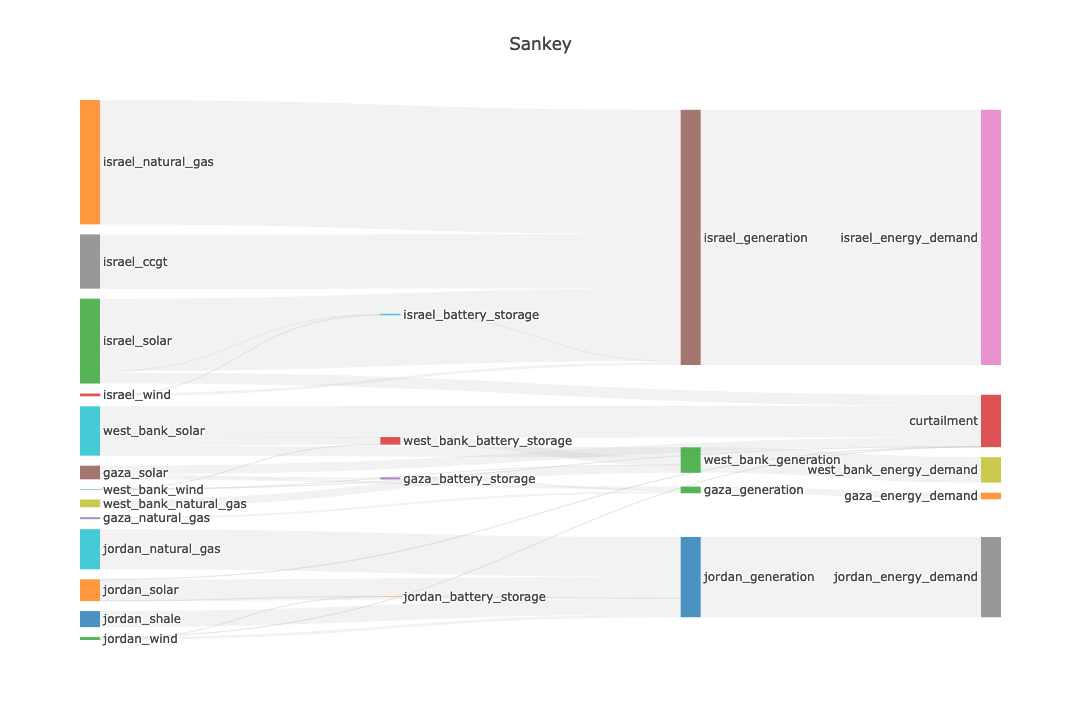

{'data': [{'type': 'sankey',
   'domain': {'x': [0, 1], 'y': [0, 1]},
   'orientation': 'h',
   'valueformat': '.0f',
   'node': {'pad': 10,
    'line': {'color': 'black', 'width': 0},
    'label': 0              egypt_generation
    1          gaza_battery_storage
    2                   gaza_diesel
    3               gaza_generation
    4              gaza_natural_gas
    5                    gaza_solar
    6        israel_battery_storage
    7                   israel_ccgt
    8                   israel_coal
    9                 israel_diesel
    10            israel_generation
    11           israel_natural_gas
    12                 israel_solar
    13                  israel_wind
    14       jordan_battery_storage
    15                  jordan_ccgt
    16                  jordan_coal
    17                jordan_diesel
    18            jordan_generation
    19           jordan_natural_gas
    20                 jordan_shale
    21                 jordan_solar
    22        

In [14]:
results.plot_flows_sankey()